In [3]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import surfreact.reactions as rx
import mpmath as mp
import matplotlib
import os
import surfreact.utils as ut
import surfreact.mlutils as mlut
import scipy.integrate
plt.style.use('plotting_style')

# $C_{ff}(t)$ Integration 

This notebook provides a workflow to integrate a $C_{ff}(t)$ time series calculated with the `runcffcalculation.py` script to get a rate constant. This notebook also plots the time series data.

In [65]:
# load datasets
MLdataset = mlut.load_MLdataset('data/MLdataset/')
cff_dataset = pd.read_json('data/cff_dataset/cff_dataset.json')

## User provided values

Edit the following values. The values entered here should match those used in calculating the $C_{ff}(t)$ time series.

- reaction number: the reaction number (1-14) for the reaction
- temperature index: position index of the temperature used for the $c_{ff}(t)$ calculation. (1-3)
- cff_data_path: Path to the .csv file saved by the `runcffcalculation.py` script

In [23]:
reaction_number = 3
temperature_index = 0
cff_data_path = 'Cffresults_reaction82755_temperature300.0K.csv'

Run the rest of the notebook cells as-is to plot the $C_ff(t)$ values and integrate the time series.

In [55]:
reaction = MLdataset[MLdataset['reaction_number'] == reaction_number]
tmax = reaction.Cff_time_converged_au.values[0][temperature_index]
T = int(reaction.Temperature_list.values[0][temperature_index])
reactionID = int(reaction['reaction_id'])

In [57]:
CFFdf = pd.read_csv(cff_data_path)

`CFFintegrator_trap` performs the integration on each Cff time series according to specified convergence criteria. The $C_{ff}(t)$ time series is integrated using the trapezoidal method. Integration starts at $t=0$ and continues until the fractional change in the value of $C_ff(t)$ between two time points is less than `fractiondelta`, or until the maximim time (8000 au) is reached. `integrate_plot` is a convenience function to perform the integration and plot the results.

In [59]:
def CFFintegrator_trap(CFFdf, fractiondelta = 0.01, t_max = 8000):
    """
    Integrates CFF to get a rate constant kQ. Written such that it integrates until change between Cff values is less than fractiondelta
    Need to figure out how to make this track a change in first derivative and 

    Parameters:
    -----------
    CFFdf: dataframe with CFF values and time points
    fractiondelta: fraction threshold for calling integration complete. Integration finished when the fraction of change between one Cff and the next is less than this value
    t_max : max t to integrate to - if not converged by here, integration will be stopped

    Returns:
    --------
    CFFint (float): value of integral
    i (int): Index of CFFarr for which reflection calcualated to have occured.
    """

    CFFint = 0

    for i, row in CFFdf.iterrows():
        if i>0: # skip first row
            CFFnow = row['Cff values']
            CFFlast = CFFdf.loc[i-1, 'Cff values']
            t = row['time [au]']
            #check if tmax has been reached and break out of loop if it has 
            if t > t_max:
                print('t_max reached before convergence criteria met')
                #print('Cff at tmax: ', CFFint)
                break
                
            tlast = CFFdf.loc[i-1, 'time [au]']
            
            # check for convergence criteria
            delta = abs((CFFnow - CFFlast)/CFFnow)
            if delta < fractiondelta and i>10:
                print(delta)
                print('breaking out at cff val ', CFFint)
                break
            else:
                CFFint+=((CFFnow+CFFlast)/2)*(t - tlast)

    return CFFint, i

In [76]:
def integrate_plot(T, CFFdf, fractiondelta = 0.001, t_max = 8000):
    """
    Convenience function to integrate and plot Cff
    """
    CFFint, converged_index = CFFintegrator_trap(CFFdf, fractiondelta=fractiondelta, t_max = t_max)
    
    #print(converged_index)

    converged_time = CFFdf['time [au]'][converged_index]
    print('kQ Cff: {}'.format(CFFint))
    print('Time converged at: {}'.format(CFFdf['time [au]'][converged_index]))

    fig, ax = plt.subplots(figsize = (8,8))

    ax.plot(CFFdf['time [au]'], CFFdf['Cff values'], label = r'$C_{ff}(t)$')
    ax.set_title(r'$C_{{ff}}(t)$ for Temp. {}, reaction {}'.format(T, reaction_number))
    ax.vlines(CFFdf['time [au]'][converged_index], 0, CFFdf['Cff values'][0], color = 'r', label = 'max time integrated')
    ax.set_xlabel('Time [au]')
    ax.set_ylabel(r'$C_{ff}(t)$')
    #ax.set_xlim(0, 10000)
    plt.tight_layout()        
    plt.legend()

    return CFFint, converged_time

Actual code to run integration:

t_max reached before convergence criteria met
kQ Cff: -7.030126320508584e-14
Time converged at: 8015


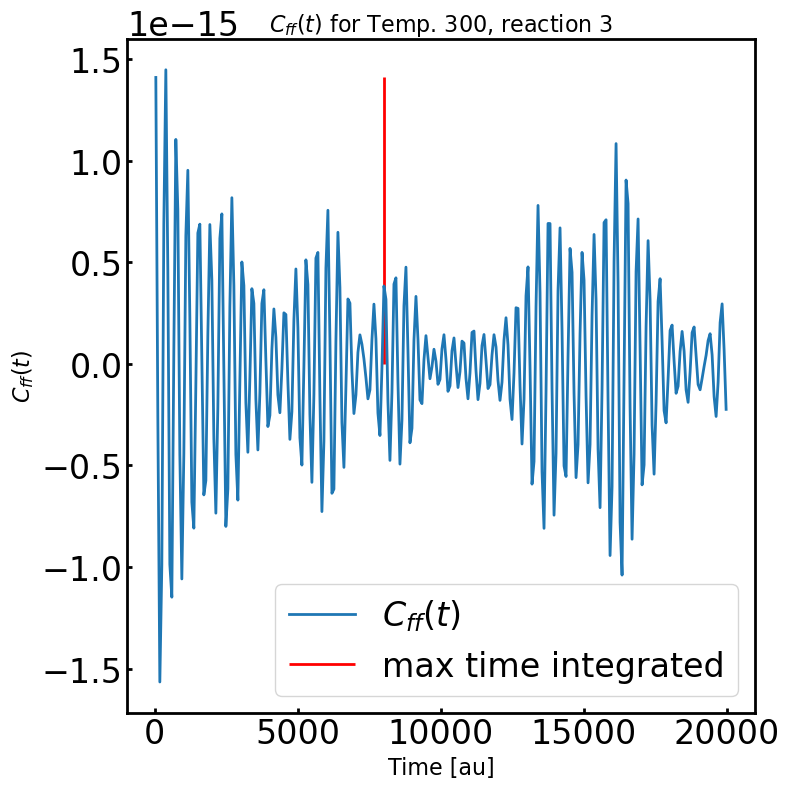

In [77]:
CFFint, converged_time = integrate_plot(T, CFFdf, fractiondelta = 0.001, t_max = 8000)

The value `CFFint` is the integrated rate constant $kQ_{Cff}$. To regenerate the machine learning dataset, integrate the time series for every reaction and temperature combination and collect the rate constants in one file.